# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lab 4: Multiple and Polynomial Regression 

**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors:** Pavlos Protopapas and Kevin Rader<br/>
**Lab Instructor:** Rahul Dave<br/>
**Authors:** Rahul Dave, David Sondak, Will Claybaugh, Pavlos Protopapas

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Table of Contents

<ol start="0">
<li> Learning Goals </li>
<li> Polynomial Regression, and Revisiting the Cab Data</li>
<li> Multiple regression and exploring the Football data </li>
<li> A nice trick for forward-backwards </li>
</ol>

## Learning Goals
After this lab, you should be able to
 - Implement arbitrary multiple regression models in both SK-learn and Statsmodels
 - Interpret the coefficent estimates produced by each model, including transformed and dummy variables

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

`statsmodels` is focused on the _inference_ task: guess good values for the betas and discuss how certain you are in those answers. 

`sklearn` is focused on the _prediction_ task: given \[new\] data, guess what the response value is. As a result, statsmodels has lots of tools to discuss confidence, but isn't great at dealing with test sets. Sklearn is great at test sets and validations, but can't really discuss uncertainty in the parameters or predictions. In short:

  - sklearn is about putting a line through it and predicting new values using that line. If the line gives good predictions on the test set, who cares about anything else?
  - statsmodels assumes more about how the data were generated, and (if the assumptions are correct) can tell you about uncertainty in the results


### Some terms


- **R-squared**: An interpretable summary of how well the model did. 1 is perfect, 0 is a trivial baseline model, negative is worse than the trivial model
- **F-statistic**: A value testing whether we're likely to see these results (or even stronger ones) if none of the predictors actually mattered.
- **Prob (F-statistic)**: The probability that we'd see these results (or even stronger ones) if none of the predictors actually mattered. If this probability is small then either A) some combination of predictors actually matters or B) something rather unlikely has happened
- **coef**: The estimate of each beta. This has several sub-components:
  - **std err**: The amount we'd expect this value to wiggle if we re-did the data collection and re-ran our model. More data tends to make this wiggle smaller, but sometimes the collected data just isn't enough to pin down a particular value.
  - **t and P>|t|**: similar to the F-statistic, these measure the probability of seeing coefficients this big (or even bigger) if the given variable didn't actually matter. Small probability doesn't necessarily mean the value matters
  - **\[0.025 0.975\]**: Endpoints of the 95% confidence interval. This is a interval drawn in a clever way and which gives an idea of where the true beta value might plausibly live. (If you want to understand why "there's a 95% chance the true beta is in the interval" is _wrong_, start a chat with Will : )
  

## Part 1: Polynomial Regression, and Revisiting the Cab Data

In [3]:
# read in the data, break into train and test
cab_df = pd.read_csv("data/dataset_1.txt")
train_data, test_data = train_test_split(cab_df, test_size=.2, random_state=42)
cab_df.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [4]:
cab_df.shape

(1250, 2)

In [7]:
# do some data cleaning
X_train = train_data['TimeMin'].values.reshape(-1,1)/60
y_train = train_data['PickupCount'].values

X_test = test_data['TimeMin'].values.reshape(-1,1)/60
y_test = test_data['PickupCount'].values


def plot_cabs(cur_model, poly_transformer=None):
    
    # build the x values for the prediction line
    x_vals = np.arange(0,24,.1).reshape(-1,1)
    
    # if needed, build the design matrix
    if poly_transformer:
        design_mat = poly_transformer.fit_transform(x_vals)
    else:
        design_mat = x_vals
    
    # make the prediction at each x value
    prediction = cur_model.predict(design_mat)
    
    # plot the prediction line, and the test data
    plt.plot(x_vals,prediction, '.-', color='k', label="Prediction")
    plt.scatter(X_test, y_test, label="Test Data")

    # label your plots
    plt.ylabel("Number of Taxi Pickups")
    plt.xlabel("Time of Day (Hours Past Midnight)")
    plt.legend()
    plt.show()

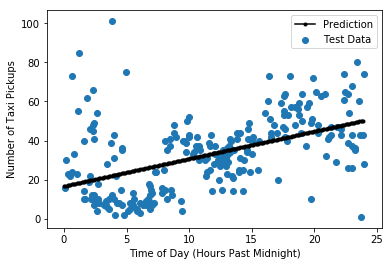

In [8]:
from sklearn.linear_model import LinearRegression
fitted_cab_model0 = LinearRegression().fit(X_train, y_train)
plot_cabs(fitted_cab_model0)

In [9]:
fitted_cab_model0.score(X_test, y_test)

0.240661535615741

We can see that there's still a lot of variation in cab pickups that's not being caught by a linear fit. And the linear fit is predicting massively more pickups at 11:59pm than at 12:00am. However, we can add columns to our design matrix for $TimeMin^2$ and $TimeMin^3$ and so on, allowing a wigglier polynomial that will better fit the data.

We'll be using sklearn's `PolynomialFeatures` to take some of the tedium out of building the new design matrix. In fact, if all we want is a formula like $y \approx \beta_0 + \beta_1 x + \beta_2 x^2 + ...$ it will directly return the new design matrix.

In [23]:
tra = PolynomialFeatures(3, include_bias=True)
xx1 = np.linspace(0,1, 5)
xx2 = np.linspace(9,10, 5)
xx1, xx2

(array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ]),
 array([  9.  ,   9.25,   9.5 ,   9.75,  10.  ]))

In [28]:
xx3 = np.concatenate([xx1.reshape(-1,1),xx2.reshape(-1,1)], axis = 1)
xx3

array([[  0.  ,   9.  ],
       [  0.25,   9.25],
       [  0.5 ,   9.5 ],
       [  0.75,   9.75],
       [  1.  ,  10.  ]])

In [29]:
tra = PolynomialFeatures(2, include_bias=False)
tra.fit_transform(xx3)

array([[  0.00000000e+00,   9.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   8.10000000e+01],
       [  2.50000000e-01,   9.25000000e+00,   6.25000000e-02,
          2.31250000e+00,   8.55625000e+01],
       [  5.00000000e-01,   9.50000000e+00,   2.50000000e-01,
          4.75000000e+00,   9.02500000e+01],
       [  7.50000000e-01,   9.75000000e+00,   5.62500000e-01,
          7.31250000e+00,   9.50625000e+01],
       [  1.00000000e+00,   1.00000000e+01,   1.00000000e+00,
          1.00000000e+01,   1.00000000e+02]])

In [22]:
transformer_3 = PolynomialFeatures(3, include_bias=False)
new_features = transformer_3.fit_transform(X_train)
new_features

array([[  6.73333333e+00,   4.53377778e+01,   3.05274370e+02],
       [  2.18333333e+00,   4.76694444e+00,   1.04078287e+01],
       [  1.41666667e+00,   2.00694444e+00,   2.84317130e+00],
       ..., 
       [  1.96666667e+01,   3.86777778e+02,   7.60662963e+03],
       [  1.17333333e+01,   1.37671111e+02,   1.61534104e+03],
       [  1.42000000e+01,   2.01640000e+02,   2.86328800e+03]])

A few notes on `PolynomialFeatures`:

- The interface is a bit strange. `PolynomialFeatures` is a 'transformer' in sklearn. We'll be using several transformers that learn a transformation on the training data and then apply that transformation on future data. On these (more typical) transformers it makes sense to have a `.fit()` and a separate `.transform()`. With PolynomialFeatures, the `.fit()` is pretty trivial, and we often fit and transform in one command, as seen above.
- You rarely want to `include_bias` (a column of all 1s), since sklearn will add it automatically and statsmodels can just `add_constant` right before you fit to the design matrix
- If you want polynomial features for a several different variables, you should call `.fit_transform()` separately on each column and append all the results to the design matrix (unless you also want interaction terms between the newly-created features). See `np.concatenate` for joining arrays.

In [ ]:
fitted_cab_model3 = LinearRegression().fit(new_features, y_train)
plot_cabs(fitted_cab_model3, transformer_3)

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. Calculate the polynomial model's $R^2$ performance on the test set. 
2. Does the polynomial model improve on the purely linear model?
3. Make a residual plot for the polynomial model. What does this plot tell us about the model?

*your answer here*
1. See code below
2. Yes, the test set $R^2$ is higher, and the visual fit to both data sets is much better. It even looks like the predicted number of pickups at 11:59 pm and 12:00 am are nearly equal.
3. See the code below. The residuals are much more evenly spread than with the linear model [not shown, but trust us], but they still don't look like an even spread of gaussian noise. This makes it unlikely that the statsmodel assumptions are valid, and we might want to be careful about trusting confidence intervals, etc, and we may want to search for other models entirely.

In [ ]:
# your code here
# test r-squared
print("Test R-squared:", fitted_cab_model3.score(transformer_3.fit_transform(X_test), y_test))

In [ ]:
# your code here
design_mat = transformer_3.fit_transform(X_train)

prediction = fitted_cab_model3.predict(design_mat)
residual = y_train - prediction
plt.scatter(X_train, residual, label="Residual")
plt.axhline(0, color='k')

plt.title("Residuals for the Cubic Model")
plt.ylabel("Residual Number of Taxi Pickups")
plt.xlabel("Time of Day (Hours Past Midnight)")
plt.legend()

In [ ]:
# your code here
design_mat = X_train

prediction = fitted_cab_model0.predict(design_mat)
residual = y_train - prediction
plt.scatter(X_train, residual, label="Residual")
plt.axhline(0, color='k')

plt.title("Residuals for the Linear Model")
plt.ylabel("Residual Number of Taxi Pickups")
plt.xlabel("Time of Day (Hours Past Midnight)")
plt.legend()

#### Other features
Polynomial features are not the only constucted features that help fit the data. Because these data have a 24 hour cycle, we may want to build features that follow such a cycle. For example, $sin(24\frac{x}{2\pi})$, $sin(12\frac{x}{2\pi})$, $sin(8\frac{x}{2\pi})$. Other feature transformations are appropriate to other types of data. For instance certain feature transformations have been developed for geographical data.

<hr style="height:3px">
## Part 2: Multiple regression and exploring the Football data
Let's move on to a truly interesting dataset. The data imported below were scraped by [Shubham Maurya](https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data) and record various facts about players in the English Premier League. Our goal will be to fit models that predict the players' market value (what the player could earn when hired by a new team), as estimated by transfermrkt.com.

`name`: Name of the player  
`club`: Club of the player  
`age` : Age of the player  
`position` : The usual position on the pitch  
`position_cat` :  1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers  
`market_value` : As on transfermrkt.com on July 20th, 2017  
`page_views` : Average daily Wikipedia page views from September 1, 2016 to May 1, 2017  
`fpl_value` : Value in Fantasy Premier League as on July 20th, 2017  
`fpl_sel` : % of FPL players who have selected that player in their team  
`fpl_points` : FPL points accumulated over the previous season  
`region`: 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World  
`nationality`: Player's nationality  
`new_foreign`: Whether a new signing from a different league, for 2017/18 (till 20th July)  
`age_cat`: a categorical version of the Age feature  
`club_id`: a numerical version of the Club feature  
`big_club`: Whether one of the Top 6 clubs  
`new_signing`: Whether a new signing for 2017/18 (till 20th July)  

As always, we first import, verify, split, and explore the data.

## Part 2.1: Import and verification and grouping

In [30]:
league_df = pd.read_csv("data/league_data.txt")
print(league_df.dtypes)
league_df.head()

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_value       float64
fpl_sel          object
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
dtype: object


,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [31]:
league_df.shape

(461, 17)

In [32]:
league_df.describe()

,age,position_cat,market_value,page_views,fpl_value,fpl_points,region,new_foreign,age_cat,club_id,big_club,new_signing
count,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,460.000000,461.000000,461.000000,461.000000,461.000000,461.000000
mean,26.804772,2.180043,11.012039,763.776573,5.447939,57.314534,1.993478,0.034707,3.206074,10.334056,0.303688,0.145336
std,3.961892,1.000061,12.257403,931.805757,1.346695,53.113811,0.957689,0.183236,1.279795,5.726475,0.460349,0.352822
min,17.000000,1.000000,0.050000,3.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,24.000000,1.000000,3.000000,220.000000,4.500000,5.000000,1.000000,0.000000,2.000000,6.000000,0.000000,0.000000
50%,27.000000,2.000000,7.000000,460.000000,5.000000,51.000000,2.000000,0.000000,3.000000,10.000000,0.000000,0.000000
75%,30.000000,3.000000,15.000000,896.000000,5.500000,94.000000,2.000000,0.000000,4.000000,15.000000,1.000000,0.000000
max,38.000000,4.000000,75.000000,7664.000000,12.500000,264.000000,4.000000,1.000000,6.000000,20.000000,1.000000,1.000000


### (Stratified) train/test split
We want to make sure that the training and test data have appropriate representation of each region; it would be bad for the training data to entirely miss a region. This is especially important because some regions are rather rare.

<div class="exercise"><b>Exercise</b></div>
**Questions**:
1. Use the `train_test_split` function to and its 'stratify' argument to split the data, keeping equal representation of each region (This will not work out of the box on this data. Deal with the resulting issue).
2. Deal with the issue you encountered above.
3. How did you deal with the error generated by `train_test_split`? How did you justify your action? 

*your answer here*:
1. See below. We pass the `stratify` argument the data that we want to keep even across train and test sets.
2. See below.
2. Since only one data point has a missing value, we just drop it. +/- one point doesn't seem like it would impact the analysis too much. Of course, someone who knew the premier league might be able to tell which region this player should be in and simply correct the missing value.

In [33]:
# your code here
try:
    # Doesn't work: a value is missing
    train_data, test_data = train_test_split(league_df, test_size = 0.2, 
                                             stratify=league_df['region'])
except:
    # Count the missing lines and drop them
    missing_rows = np.isnan(league_df['region'])
    print("Uh oh, {} lines missing data! Dropping them".format(np.sum(missing_rows)))
    league_df = league_df.dropna(subset=['region'])
    train_data, test_data = train_test_split(league_df, test_size = 0.2, 
                                             stratify=league_df['region'])

Uh oh, 1 lines missing data! Dropping them


In [34]:
train_data.shape, test_data.shape

((368, 17), (92, 17))

Now that we won't be peeking at the test set, let's explore and look for patterns! We'll introduce a number of useful pandas and numpy functions along the way. 

### Groupby
Pandas' `.groupby()` function is a wonderful tool for data analysis. It allows us to analyze each of several subgroups.

Many times, `.groupby()` is combined with `.agg()` to get a summary statistic for each subgroup. For instance: What is the average market value, median page views, and maximum fpl for each player position?

In [35]:
train_data.groupby('position').agg({
    'market_value': np.mean,
    'page_views': np.median,
    'fpl_points': np.max
})

,market_value,page_views,fpl_points
position,,,
AM,25.711538,1413.0,218
CB,9.476923,338.0,178
CF,13.852041,781.0,224
CM,11.361111,420.5,225
DM,13.339286,477.0,131
GK,6.237097,402.0,149
LB,8.490741,345.0,177
LM,4.375000,325.5,99
LW,14.243548,474.0,264


In [38]:
train_data.position.unique()

array(['CF', 'CM', 'CB', 'GK', 'RW', 'DM', 'RB', 'LB', 'LW', 'AM', 'LM',
       'SS', 'RM'], dtype=object)

In [39]:
train_data.groupby(['big_club', 'position']).agg({
    'market_value': np.mean,
    'page_views': np.mean,
    'fpl_points': np.mean
})

market_value   page_views  fpl_points
big_club position                                       
0        AM           13.208333   563.166667   68.666667
         CB            4.771739   298.652174   41.152174
         CF            8.878571   886.828571   55.428571
         CM            5.687500   355.775000   38.325000
         DM            7.777778   465.111111   42.722222
         GK            4.137500   379.100000   44.900000
         LB            5.065789   247.578947   51.526316
         LM            4.375000   370.500000   52.833333
         LW            6.309524   441.619048   45.523810
         RB            4.750000   260.190476   51.904762
         RM            4.333333   280.333333    1.666667
         RW            7.967391   543.173913   48.695652
         SS            7.300000  1969.000000   55.800000
1        AM           36.428571  2473.857143  142.857143
         CB           20.868421  1016.789474   72.526316
         CF           26.285714  2390.714286   84.714286
         CM           27.571429  2158.142857   93.714286
         DM           23.350000  1340.600000   63.300000
         GK           10.054545   769.909091   52.909091
         LB           16.625000   914.875000   70.500000
         LW           30.905000  2150.100000  116.900000
         RB           18.583333   994.166667  102.833333
         RM           20.000000  2028.000000   94.000000
         RW           28.250000  1415.750000   78.000000

<hr style="height:3px">
## Part 2.2: Linear regression on the football data
This section of the lab focuses on fitting a model to the football data and interpreting the model results. The model we'll use is

$$\text{market_value} \approx \beta_0 + \beta_1\text{fpl_points} + \beta_2\text{age} + \beta_3\text{age}^2 + \beta_4log_2\left(\text{page_views}\right) + \beta_5\text{new_signing} +\beta_6\text{big_club} + \beta_7\text{position_cat}$$

We're including a 2nd degree polynomial in age because we expect pay to increase as a player gains experience, but then decrease as they continue aging. We're taking the log of page views because they have such a large, skewed range and the transformed variable will have fewer outliers that could bias the line. We choose the base of the log to be 2 just to make interpretation cleaner.

<div class="exercise"><b>Exercise</b></div>
**Questions**:
1. Build a design matrix function and fit this model to the training data. How good is the overall model?
2. Interpret the regression model. What is the meaning of the coefficient for:
    - age and age$^2$
    - $log_2($page_views$)$
    - big_club
2. What should a player do in order to improve their market value? How many page views should a player go get to increase their market value by 10?

In [ ]:
# your code here
# building design matrices happens after explore
y_train = train_data['market_value']
y_test = test_data['market_value']

def build_model2_design(df):
    design_mat = df[['fpl_points','age','new_signing','big_club','position_cat']].copy()
    design_mat['log_views'] = np.log2(df['page_views'])
    design_mat['age_squared'] = df['age']**2
    
    #reindex so variables are in a pretty order
    design_mat = design_mat[['fpl_points','age','age_squared','log_views','new_signing','big_club','position_cat']]
    
    design_mat = sm.add_constant(design_mat)
    
    return design_mat

train_design = build_model2_design(train_data)
test_design = build_model2_design(test_data)

fitted_model_1 = OLS(endog= y_train, exog= train_design, hasconst=True).fit()
fitted_model_1.summary()

In [ ]:
# your code here
# test set r-squared
r2_score(y_test, fitted_model_1.predict(test_design))

*your answer here*

1. The model is reasonably good. We're capturing about 67% of the variation in market values, and the test set confirms that we're not overfitting too badly.
2. Look at the coefficients, depends upon your split..
3. Linear regression on non-experimental data can't determine causation, so we can't prove that a given relationship runs in the direction we might think. For instance, doing whatever it takes to get more page views probably doesn't meaningfully increase market value; it's likely the causation runs in the other direction and great players get more views. Even so, we can use page views to help us tell who is a great player and thus likely to be paid well.

In [ ]:
agecoef = fitted_model_1.params.age
age2coef = fitted_model_1.params.age_squared

In [ ]:
x_vals = np.linspace(-100,100,1000)
y_vals = agecoef*x_vals +age2coef*x_vals**2
plt.plot(x_vals, y_vals)
plt.title("Effect of Age")
plt.xlabel("Age")
plt.ylabel("Contribution to Predicted Market Value")
plt.show()

<hr style='height:3px'>
### Part 2.3: Turning Categorical Variables into multiple binary variables
Of course, we have an error in how we've included player position. Even though the variable is numeric (1,2,3,4) and the model runs without issue, the value we're getting back is garbage. The interpretation, such as it is, is that there is an equal effect of moving from position category 1 to 2, from 2 to 3, and from 3 to 4, and that this effect is about -.61.

In reality, we don't expect moving from one position category to another to be equivalent, nor for a move from category 1 to category 3 to be twice as important as a move from category 1 to category 2. We need to introduce better features to model this variable.

We'll use `pd.get_dummies` to do the work for us.

In [ ]:
train_design_recoded = pd.get_dummies(train_design, columns=['position_cat'], drop_first=True)
test_design_recoded = pd.get_dummies(test_design, columns=['position_cat'], drop_first=True)

train_design_recoded.head()

We've removed the original `position_cat` column and created three new ones.

#### Why only three new columns?
Why does pandas give us the option to drop the first category? 

<div class="exercise"><b>Exercise</b></div>
**Questions**:
1. If we're fitting a model without a constant, should we have three dummy columns or four dummy columns?
2. Fit a model and interpret the coefficient of `position_cat_2`.


In [ ]:
resu = OLS(y_train, train_design_recoded).fit()
resu.summary()

In [ ]:
r2_score(y_test, resu.predict(test_design_recoded))

In [ ]:
train_design_recoded.shape, y_train.shape

**Answers**:
1. If our model does not have a constant, we must include all four dummy variable columns. If we drop one, we're not modeling any effect of being in that category, and effectively assuming the dropped category's effect is 0.
2. Being in position 2 (instead of position 1) has an impact between -1.54 and +2.38 on a player's market value. Since we're using an intercept, the dropped category becomes the baseline and the effect of any dummy variable is the effect of being in that category instead of the baseline category.

## Part 3: A nice trick for forward-backwards

XOR (operator ^) is a logical operation that only returns true when input differ. We can use it to implement forward-or-backwards selection when we want to keep track of whet predictors are "left" from a given list of predictors.

The set analog is "symmetric difference". From the python docs:

`s.symmetric_difference(t)	s ^ t	new set with elements in either s or t but not both`


In [ ]:
set() ^ set([1,2,3])

In [ ]:
set([1]) ^ set([1,2,3])

In [ ]:
set([1, 2]) ^ set([1,2,3])

<div class="exercise"><b>Exercise</b></div>

Outline a step-forwards algorithm which uses this idea

*your answer here*

Start with no predictors in a set, `selected_predictors`. Then the "xor" will give the set of all predictors. Go through them 1-by -1, seeing which has the highest score/ OR lowestaic/bic. Add this predictor to the `selected_predictors`.

Now repeat. The xor will eliminate this predictor from the remaining predictors. In the next iteration we will pick the next predictor which when combined with the first one gibes the lowest aic/bic of all 2-predictor models.

We repeat. We finally chose the best bic model from the 1 -predictor models, 2-predictor models, 3-predictor models and so on...